# Pràctica 2 - Classificació

## Objectius

Els objectius d'aquesta pràctica són:
  
* Aplicar models de classificació, ficant l'èmfasi en:
    1. Aplicar diferents classificadors (regressor logístic i svm) i entendre les millores d'aplicar kernels.
    2. Avaluar correctament l'error del model 
    3. Visualitzar les dades i el model resultant


* Ésser capaç d'aplicar tècniques de classificació en casos reals

* Validar els resultats en dades reals

* Fomentar la capacitat per presentar resultats tècnics d'aprenentatge computacional de forma adequada davant altres persones

## Base de dades

|	7	|	GA\*07-0000	|https://www.kaggle.com/c/titanic/data	|

# Apartat (B): Classificació Numèrica (6pts)

Per a aquest primer apartat, s'analitzarà els tipus d'atributs que es tenen i, si no està estipulat, **caldrà fixar quin és l'atribut objectiu a classificar de tots els que hi ha a la base de dades**.
Expliqueu a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.

Treballarem varis aspectes de la classificació:

1. EDA (exploratory data analysis)
2. Preprocessing (normalitzation, outlier removal, feature selection..)
3. Model Selection
4. Crossvalidation
5. Metric Analysis
6. Hyperparameter Search

### 1. EDA (exploratory data analysis)

Per começar visualitzarem les dades disponibles a la nostra base de dades i farem explorarem breument les relacions existents entre aquestes dades.

Inicialment carreguem el fitxer amb la base de dades.

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats

# Carreguem el dataset
dataset = pd.read_csv('train.csv', header=0, delimiter=',')
data = dataset.values

print("Dimensionalitat de la BBDD:", dataset.shape)

Dimensionalitat de la BBDD: (891, 12)


Comprovació de la validesa de les dades.

In [2]:
print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())

Per comptar el nombre de valors no existents:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Mirem les estadístiques principals en en una taula per veure les dades d'una manera més numérica i no tan gràfica.

In [3]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Ara mirarem la correlació de totes les dades i entendre de quina forma es relacionen.

<IPython.core.display.Javascript object>


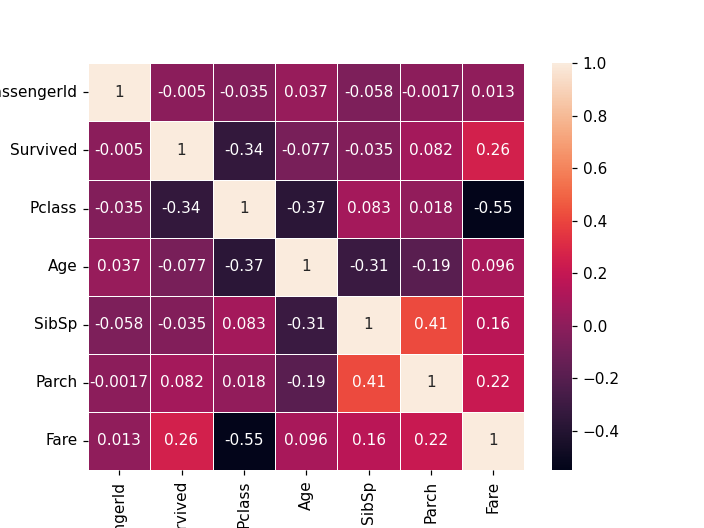

In [4]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Utilitzem pairplot per observar com es relacionen les dades d'una forma més visual.

<IPython.core.display.Javascript object>


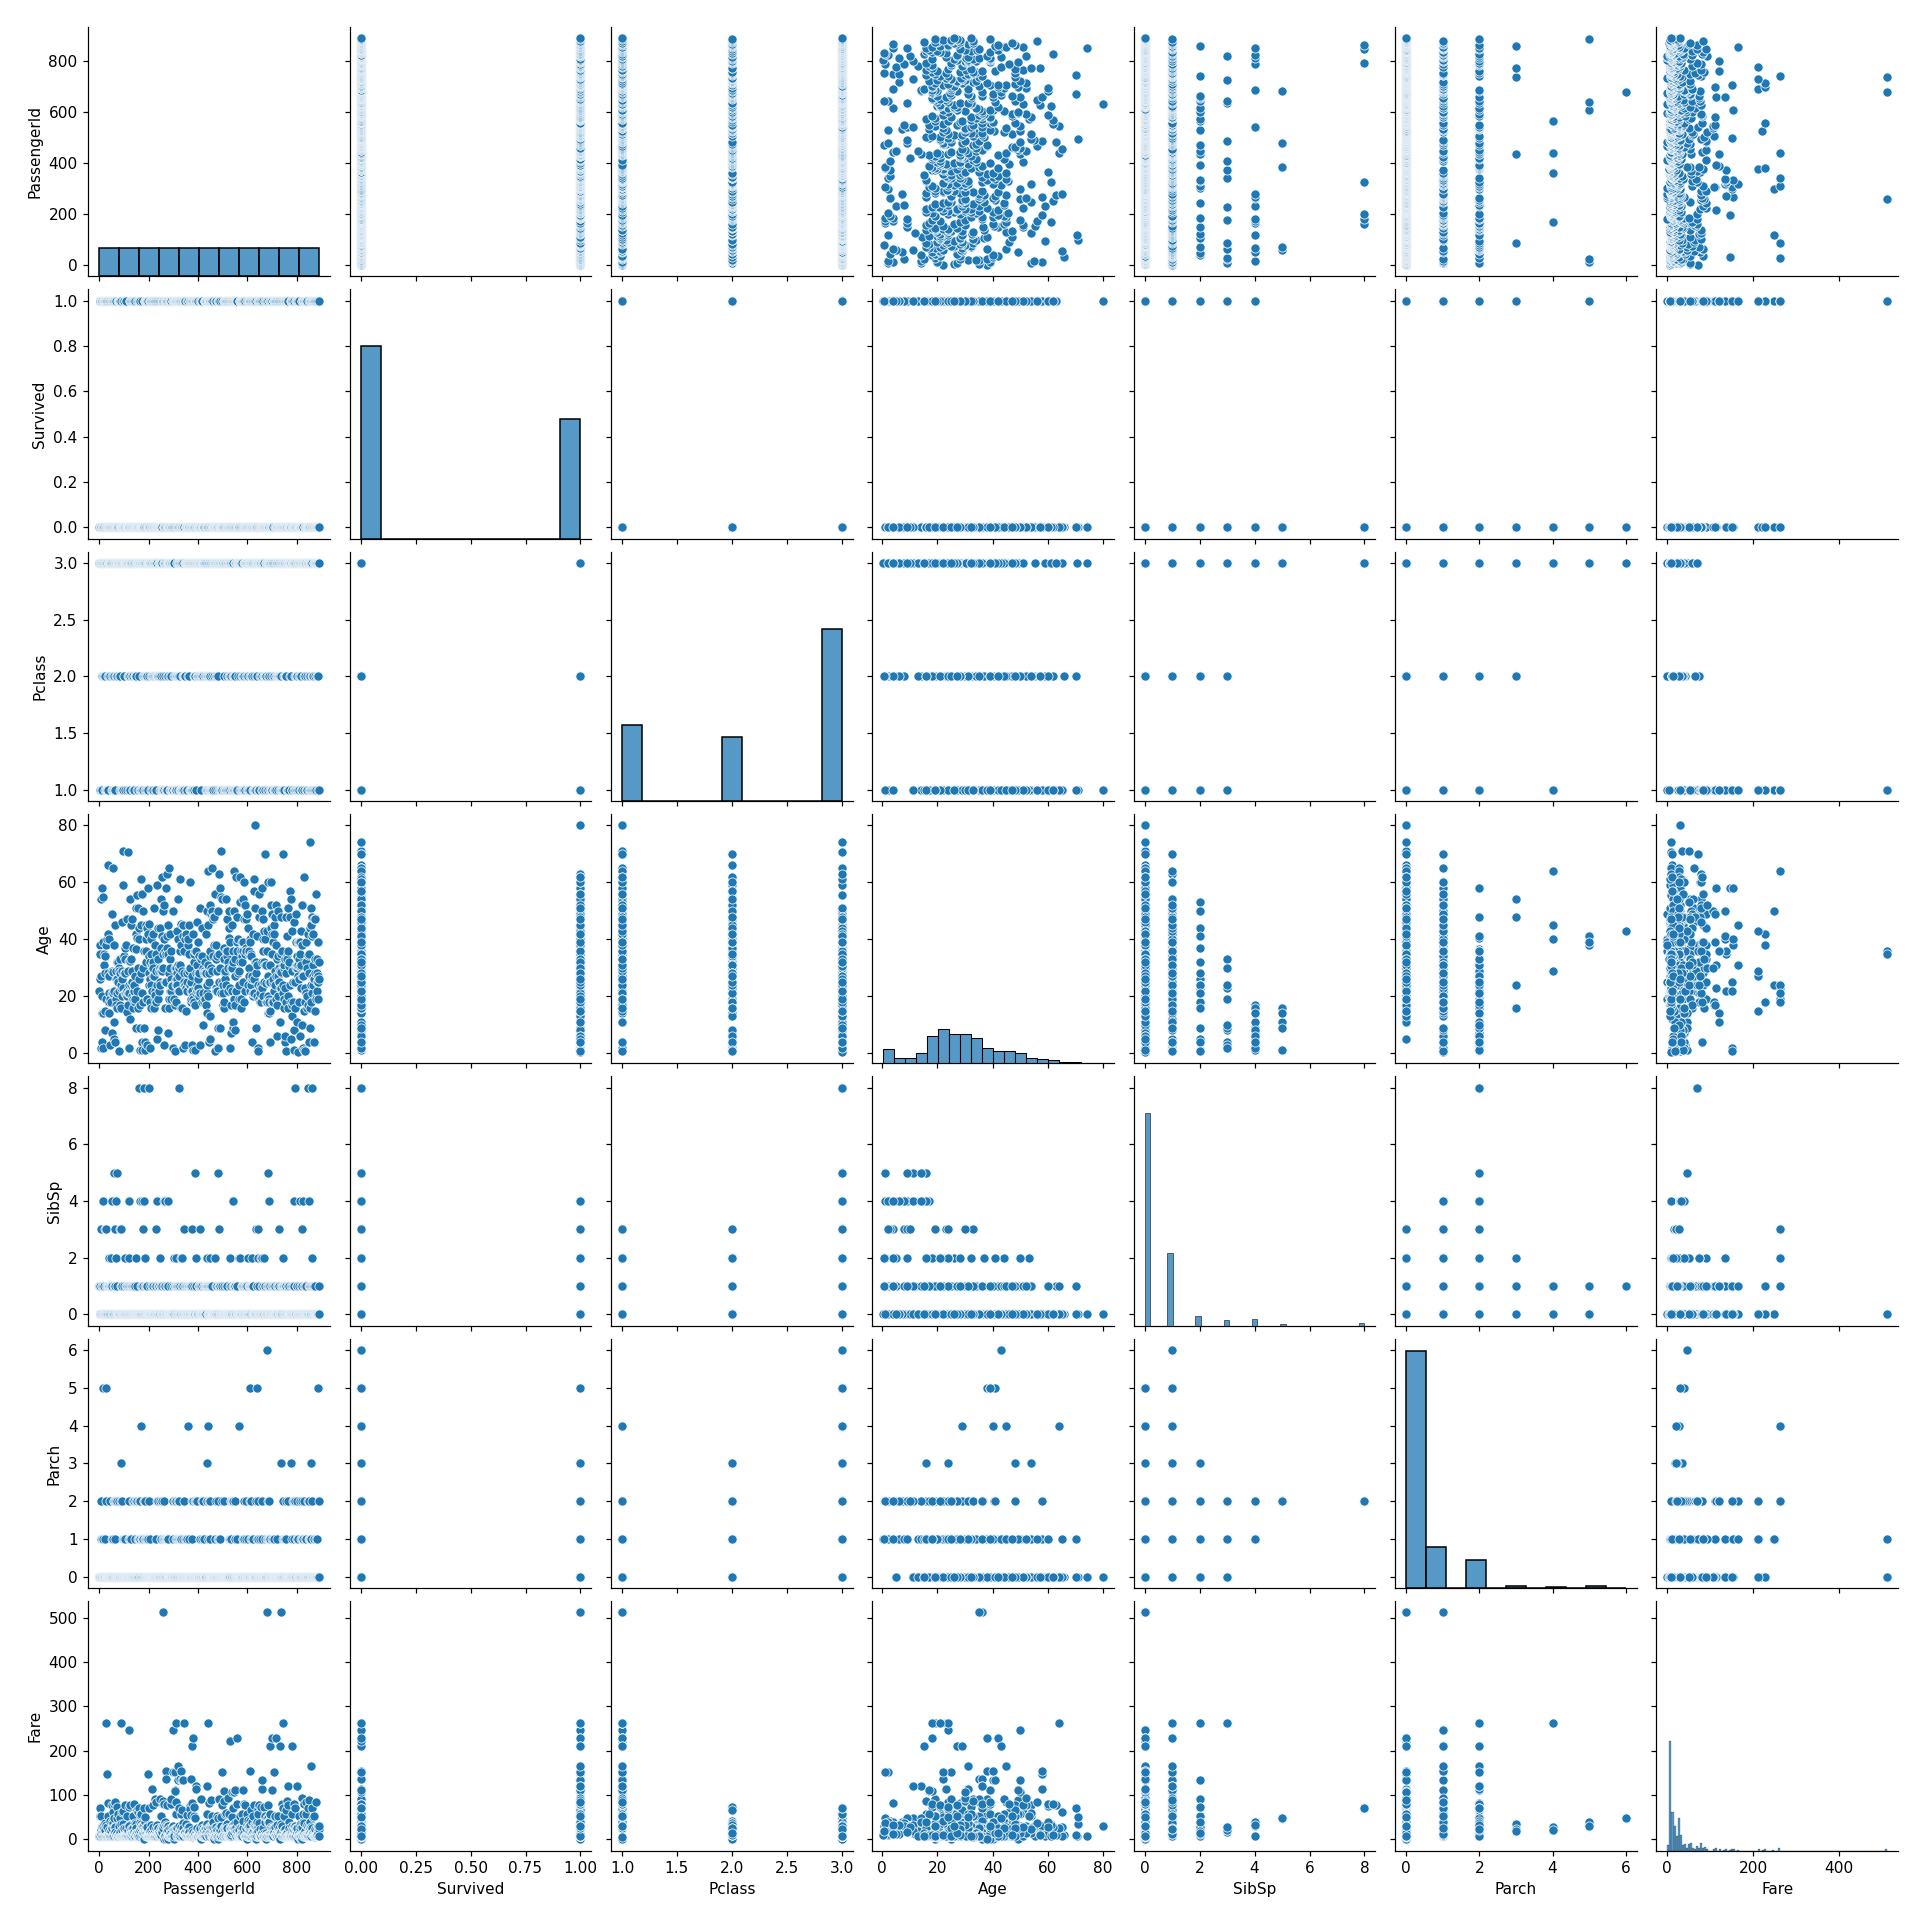

In [5]:
import seaborn as sns

relacio = sns.pairplot(dataset)

### 2. Preprocessing (normalitzation, outlier removal, feature selection..)

Una vegada observades les dades a treballar, les prepararem per poder ser utilitzades per l'entraenament i testejat del nostre model d'aprenentatge.


Inicialment, decidim eliminar els atributs 'PassengerId', 'Name', 'Ticket' i 'Cabin', ja que són dades amb valor únics que no aporten cap mena d'informació important al model. També observem que existeixen valos inexistents als atributs 'Age' i 'Embarked', per tant caldrà tractar aquestes files.

In [6]:
# Funcio per a llegir dades en format csv
def load_dataset(path, cols):
    dataset = pd.read_csv(path, header=0, delimiter=',', usecols=cols)
    return dataset

#Indexs de les columnes a utilitzar. Eliminem columnes 0 (PassengerId), 3 (Name), 8 (Ticket) i 10 (Cabin)
cols = list(range(12))
cols.remove(0)
cols.remove(3)
cols.remove(8)
cols.remove(10)

# Carreguem dataset
dataset = load_dataset('train.csv', cols)
data = dataset.values

x = data[:, 0]
y = data[:, 1:8]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)


Dimensionalitat de la BBDD: (891, 8)
Dimensionalitat de les entrades X (891,)
Dimensionalitat de l'atribut Y (891, 7)


L'estat actual de les nostres dades és el següent.

In [7]:
print('Valors nuls de cada atribut')
print(dataset.isnull().sum())

Valors nuls de cada atribut
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Al nostre dataset els atributs 'Sex' i 'Embarked' són atributs categòrics emmagatzemats en forma de texte. Per tal de processar-los correctament cal codificar-los en valors numèrics. La resta d'atributs són categòrics i numèrics.

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# Codifiquem l'atribut 'Sex'
data[:, 2] = le.fit_transform(data[:, 2])

# Codifiquem l'atribut 'Embarked'
data[:, 7] = le.fit_transform(data[:, 7])

Pel tractament dels valors inexistents als atributs 'Age' i 'Embarked' el que fem és omplir aquests buits amb el valor de la mitjana de cada columna.

In [9]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp_mean.fit_transform(data)

Creem un nou dataframe amb les dades processades.

In [10]:
dataset = pd.DataFrame(data=data, columns=list(dataset.columns))

Ara l'estat del nostre dataset és el següent.

In [11]:
print('Valors nuls de cada atribut')
print(dataset.isnull().sum())

Valors nuls de cada atribut
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


Mostrem la matriu de correlacions ara amb les dades processades.

<IPython.core.display.Javascript object>


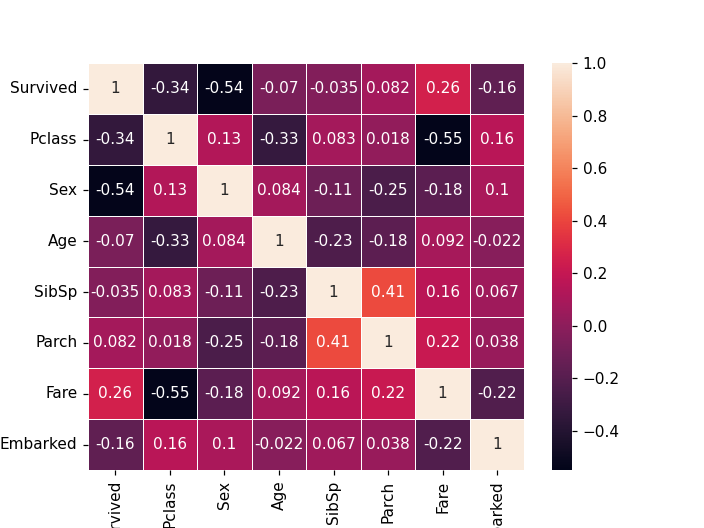

In [12]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Podem mostrar també el pairplot amb les dades processades.

<IPython.core.display.Javascript object>


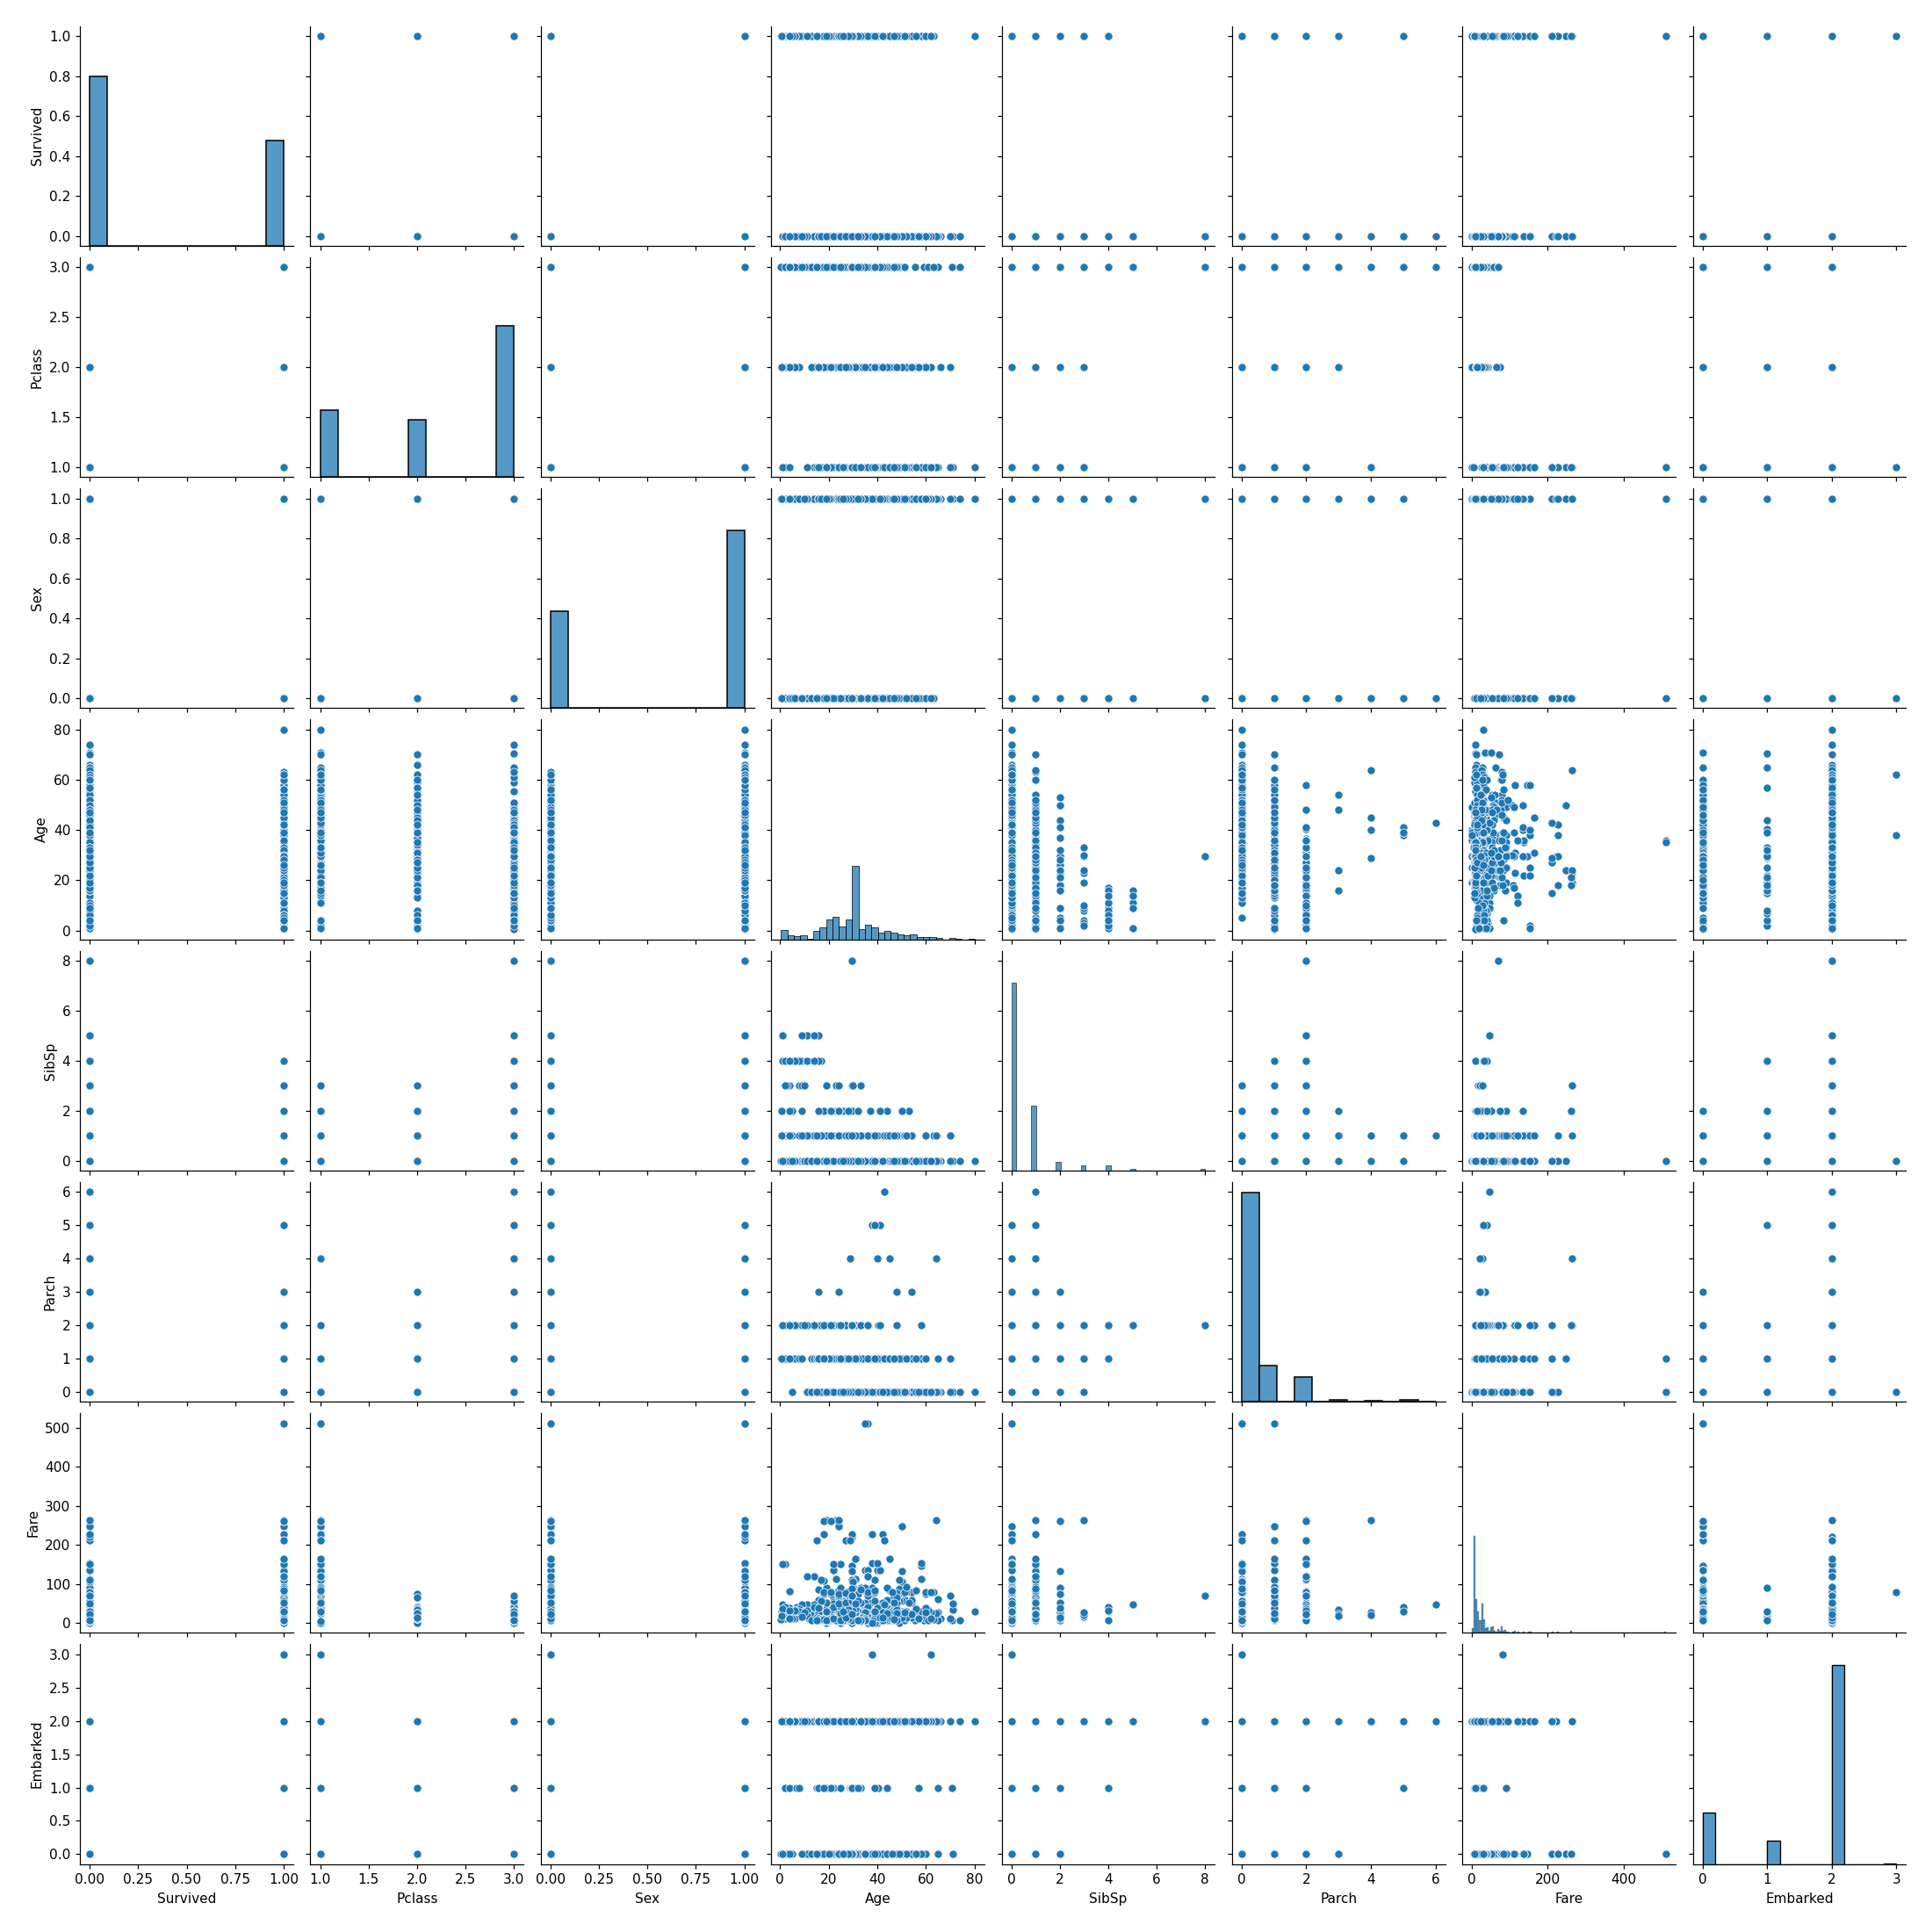

In [13]:
import seaborn as sns

relacio = sns.pairplot(dataset)

### 3. Model Selection

Farem servir un model de SVM per predir el valor de 'Survived' a partir dels valors de 'Sex' i 'pClass' que són els que valors més alts de correlació han obtingut.


In [14]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

x = data[:, 1:3] # Columnes 'Sex' i 'pClass'
y = data[:, 0] # Columna 'Survived'

# Creem el classificador SVM amb un kernel lineal
clf = svm.SVC(kernel='linear')


### 4. Crossvalidation

A continuació apliquem la tècnica de cross-validation per avaluar els resultats obtinguts pel model definit a l'apartat anterior. 

In [15]:
from sklearn.model_selection import cross_val_score

# Apliquem cross-validation sobre el model
scores = cross_val_score(clf, x, y, cv=5, scoring="accuracy") # Dividim les dades en 5 folds
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.79 accuracy with a standard deviation of 0.02


### 5. Metric Analysis
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)).

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`.
* Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset? Expliqueu amb les vostres paraules, la diferencia entre una i altre [Pista](https://stats.stackexchange.com/questions/338826/auprc-vs-auc-roc)
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina métrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

Mostrem la Precisió-Recall Curve.

<IPython.core.display.Javascript object>


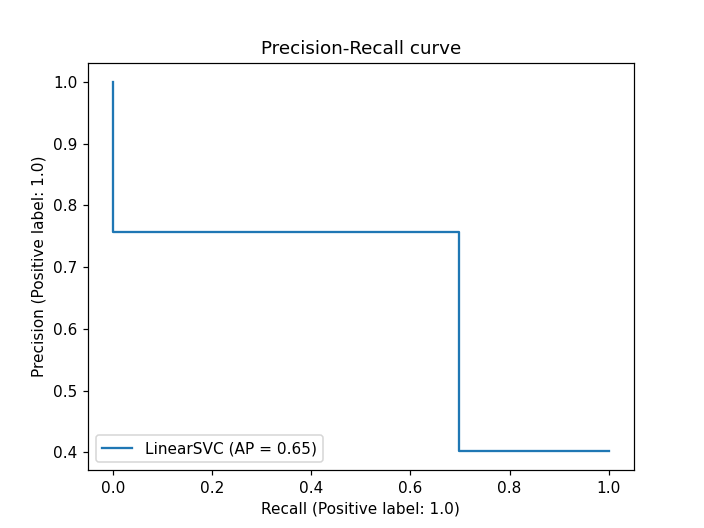

In [16]:
from sklearn.metrics import PrecisionRecallDisplay

# Dividim el dataset en 50% entrenament i 50% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

# Creem el classificador SVM amb un kernel lineal
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(x_train, y_train)

#Mostrem la corba
display = PrecisionRecallDisplay.from_estimator(
    clf, x_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("Precision-Recall curve")

I la ROC Curve quedaria de la forma següent.

<IPython.core.display.Javascript object>


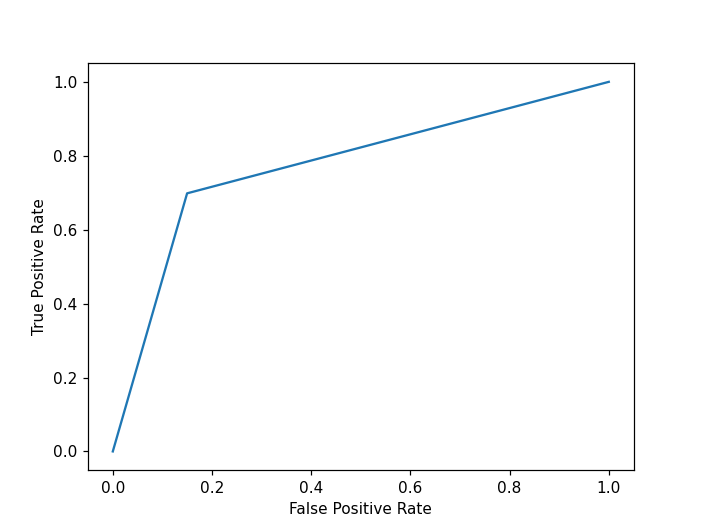

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score = clf.fit(x_train, y_train).decision_function(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 6. Hyperparameter Search
El motiu d'aplicar crossvalidació durant l'entrenament és que ens permet conèixer quin serà el resultat esperat del nostre model un cop en producció, és a dir, com es comportarà sobre dades mai vistes abans.
A més, també ens permet optimitzar quins són els hiperparametres dels models que millor funcionaran en el futur test.

**Preguntes:**
* Quines formes de buscar el millor parametre heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html)
* Si disposem de recursos limitats (per exemple, un PC durant 1 hora) quin dels dos métodes creieu que obtindrà millor resultat final?
* Existeixen altres mètodes de búsqueda més eficients ([scikit-optimize](https://scikit-optimize.github.io/stable/))?
* Feu la prova, i amb el model i el metode de crossvalidació escollit, configureu els diferents metodes de búsqueda per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (estimeu el temps que trigarà a fer 1 training, i aixi trobeu el número de intents que podeu fer en cada cas.)


In [18]:
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'], 'probability': [True, False]}
clfs = GridSearchCV(clf, params, refit=True)
clfs.fit(x_train, y_train)

print(len(clfs.cv_results_["params"]))
print(clfs.best_params_)

params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'], 'probability': [True, False]}
clfs = RandomizedSearchCV(clf, params, refit=True)
clfs.fit(x_train, y_train)

print(len(clfs.cv_results_["params"]))
print(clfs.best_params_)

96
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
10
{'probability': True, 'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
